## Comparison of Linear Regression method vs Kernel-based approximation (Kernel Trick)

In [1]:
import numpy as np
from sklearn.kernel_approximation import RBFSampler
import matplotlib.pyplot as plt

In [2]:
def generate_data(n_samples=50, noise=0.1):
    """Generate synthetic data for testing."""
    X = np.linspace(0, 5, n_samples).reshape(-1, 1)
    # This is the true Curve
    y_true = 0.5 * np.sin(X) + 0.5 * X ** 2
    y = y_true + noise * np.random.randn(n_samples, 1)
    return X, y, y_true

## Direct method
Polynomial features: 

In [3]:
def polynomial_features(X, degree=3):
    """Generate polynomial features up to specified degree."""
    features = [np.ones_like(X)]
    for d in range(1, degree + 1):
        features.append(X ** d)
    return np.hstack(features)

def direct_method(X_train, y_train, X_test, degree=3):
    """Solve using direct feature mapping."""
    # Generate polynomial features
    X_train_features = polynomial_features(X_train, degree)
    X_test_features = polynomial_features(X_test, degree)

    # Compute weights using normal equations
    w = np.linalg.solve(
        X_train_features.T @ X_train_features,
        X_train_features.T @ y_train
    )

    # Make predictions
    y_pred = X_test_features @ w
    return y_pred, w, X_train_features, X_test_features

## Kernel Methods

In [4]:
def compute_kernel_from_features(X1_features, X2_features):
    """Compute kernel matrix as dot product of feature vectors."""
    return np.dot(X1_features, X2_features.T)
    
def kernel_method(X_train_features, y_train, X_test_features):
    """Solve using kernel-based approach with explicit feature vectors."""
    # Compute kernel matrices using feature vectors
    K_train = compute_kernel_from_features(X_train_features, X_train_features)
    K_test = compute_kernel_from_features(X_test_features, X_train_features)

    # Compute alpha coefficients
    alpha = np.linalg.solve(K_train, y_train)

    # Make predictions as weighted sum of training outputs
    y_pred = K_test @ alpha
    return y_pred, alpha

# The Sutton version! It is wrong!
# def compute_kernel(x_test, X_train, degree=3):
#     """
#     Compute kernel values between test points and training points
#     using the polynomial kernel (feature space inner product).
#     """
#     x_test_features = polynomial_features(x_test, degree)
#     X_train_features = polynomial_features(X_train, degree)
#     return x_test_features @ X_train_features.T

# def kernel_method(X_train, y_train, X_test, degree=3):
#     """
#     Solve using kernel-based approach with weighted average.
#     Uses polynomial kernel to measure similarity in feature space.
#     """
#     y_pred = np.zeros((len(X_test), 1))
#
#     for i, x_test in enumerate(X_test):
#         # Compute polynomial kernel values
#         kernel_values = compute_kernel(x_test, X_train, degree)
#
#         # Normalize kernel values to get weights
#         weights = kernel_values / np.sum(kernel_values)
#
#         # Predict using weighted average
#         y_pred[i] = weights @ y_train
#
#     return y_pred

## RBF Kernel

In [5]:
def rbf_kernel_method(X_train, y_train, X_test, n_components=100, gamma=1.0,approach='inverse'):
    """
    Solve using RBFSampler to approximate the kernel method.

    Parameters:
    - n_components: number of Monte Carlo samples
    - gamma: RBF kernel parameter
    """
    # Initialize and fit RBFSampler
    rbf_feature = RBFSampler(n_components=n_components,
                             gamma=gamma,
                             random_state=42)
    rbf_feature.fit(X_train)

    # Transform data to feature space
    X_train_features = rbf_feature.transform(X_train)
    X_test_features = rbf_feature.transform(X_test)
    
    if approach == 'inverse':
        # First Approach
        # This leads to the True kernel-based result using the inverse of Training Features.
        alpha = np.linalg.solve(np.dot(X_train_features, X_train_features.T), y_train)
        y_pred = np.dot(X_test_features, X_train_features.T) @ alpha
    else:
        # Second approach (Using the weighted average of Training outputs
        # This is an approximated response which can lead to acceptable response if the gamma of each rbf
        # is chosen such that no more than one rbf components becomes active for each training output. 
        # Besides, because rbfsampler uses an approximated method, the result may not be acceptable for few components and samples
        y_pred = np.zeros((len(X_test), 1))
        for i in range(len(X_test)):
            # Compute similarities in RBF feature space
            similarities = X_test_features[i] @ X_train_features.T
            # Normalize to get weights
            weights = similarities / np.sum(similarities)
            # Predict using weighted average
            y_pred[i] = weights @ y_train

    return y_pred

## Main

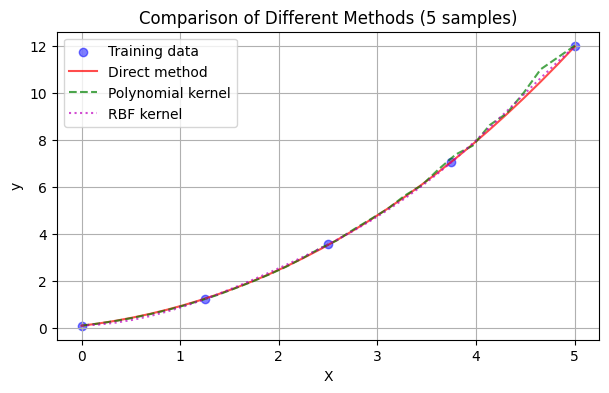

In [6]:
np.random.seed(42)
degree = 3
X_train, y_train, y_true_train = generate_data(n_samples=5, noise=0.2)
X_test, _, y_true_test = generate_data(n_samples=30, noise=0)

# Solve using all methods
y_pred_direct, weights, _,_ = direct_method(X_train, y_train, X_test, degree)

X_train_features = polynomial_features(X_train, degree)
X_test_features = polynomial_features(X_test, degree)
y_pred_kernel,_ = kernel_method(X_train_features, y_train, X_test_features)
# Use the first approach
y_pred_rbf = rbf_kernel_method(X_train, y_train, X_test, n_components=10, gamma=0.5, approach='inverse')

# X_train, y_train, y_true_train = generate_data(n_samples=100, noise=0.2)
# rbf_feature = RBFSampler(n_components=100,
#                              gamma=0.5,
#                              random_state=42)
# rbf_feature.fit(X_train)
# X_train_features = rbf_feature.transform(X_train)
# X_test_features = rbf_feature.transform(X_test)
# print(X_train_features)
#print(rbf_feature.random_weights_)

# plot
plt.figure(figsize=(7, 4))
plt.scatter(X_train, y_train, c='b', label='Training data', alpha=0.5)
plt.plot(X_test, y_pred_direct, 'r-', label='Direct method', alpha=0.7)
plt.plot(X_test, y_pred_kernel, 'g--', label='Polynomial kernel', alpha=0.7)
plt.plot(X_test, y_pred_rbf, 'm:', label='RBF kernel', alpha=0.7)
plt.title('Comparison of Different Methods (5 samples)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## Second approach of RBF kernel

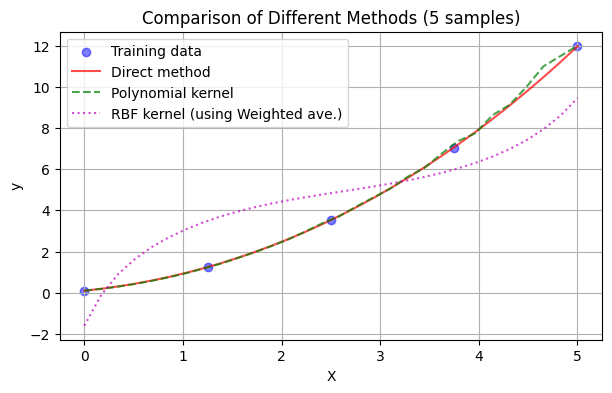

In [7]:
np.random.seed(42)
degree = 3
X_train, y_train, y_true_train = generate_data(n_samples=5, noise=0.2)
X_test, _, y_true_test = generate_data(n_samples=30, noise=0)

# Solve using all methods
y_pred_direct, weights, _,_ = direct_method(X_train, y_train, X_test, degree)

X_train_features = polynomial_features(X_train, degree)
X_test_features = polynomial_features(X_test, degree)
y_pred_kernel,_ = kernel_method(X_train_features, y_train, X_test_features)
# Use the first approach
y_pred_rbf = rbf_kernel_method(X_train, y_train, X_test, n_components=10, gamma=0.5, approach='weightedAverage')

# Plot
plt.figure(figsize=(7, 4))
plt.scatter(X_train, y_train, c='b', label='Training data', alpha=0.5)
plt.plot(X_test, y_pred_direct, 'r-', label='Direct method', alpha=0.7)
plt.plot(X_test, y_pred_kernel, 'g--', label='Polynomial kernel', alpha=0.7)
plt.plot(X_test, y_pred_rbf, 'm:', label='RBF kernel (using Weighted ave.)', alpha=0.7)
plt.title('Comparison of Different Methods (5 samples)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

Increasing the Number of Training samples.

This results in numeric problems for the polynomial kernels because it should compute the inverse of an NxN matrix

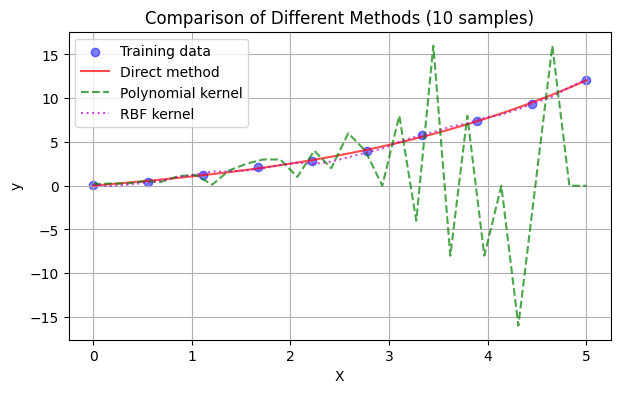

In [8]:
np.random.seed(42)
degree = 3
X_train, y_train, y_true_train = generate_data(n_samples=10, noise=0.2)
X_test, _, y_true_test = generate_data(n_samples=30, noise=0)

# Solve using all methods
y_pred_direct, weights, _,_ = direct_method(X_train, y_train, X_test, degree)

X_train_features = polynomial_features(X_train, degree)
X_test_features = polynomial_features(X_test, degree)
y_pred_kernel,_ = kernel_method(X_train_features, y_train, X_test_features)
# Use the first approach
y_pred_rbf = rbf_kernel_method(X_train, y_train, X_test, n_components=10, gamma=0.5, approach='inverse')

# Plot
plt.figure(figsize=(7, 4))
plt.scatter(X_train, y_train, c='b', label='Training data', alpha=0.5)
plt.plot(X_test, y_pred_direct, 'r-', label='Direct method', alpha=0.7)
plt.plot(X_test, y_pred_kernel, 'g--', label='Polynomial kernel', alpha=0.7)
plt.plot(X_test, y_pred_rbf, 'm:', label='RBF kernel', alpha=0.7)
plt.title('Comparison of Different Methods (10 samples)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

Increasing the number of components in RBF kernels results in better estimation 

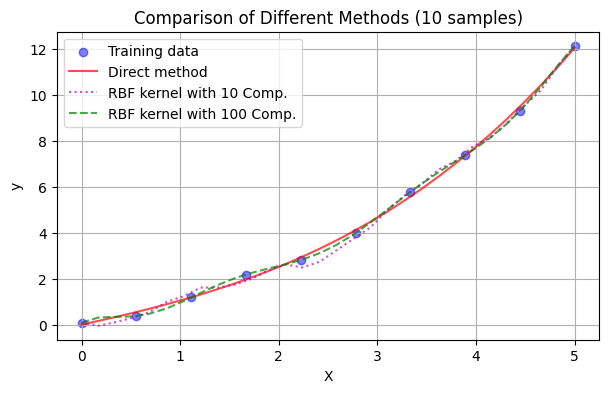

In [9]:
np.random.seed(42)
degree = 3
X_train, y_train, y_true_train = generate_data(n_samples=10, noise=0.2)
X_test, _, y_true_test = generate_data(n_samples=30, noise=0)

# Solve using all methods
y_pred_direct, weights, _,_ = direct_method(X_train, y_train, X_test, degree)

X_train_features = polynomial_features(X_train, degree)
X_test_features = polynomial_features(X_test, degree)
y_pred_kernel,_ = kernel_method(X_train_features, y_train, X_test_features)
# Use the first approach
y_pred_rbf_10 = rbf_kernel_method(X_train, y_train, X_test, n_components=10, gamma=0.5, approach='inverse')
y_pred_rbf_100 = rbf_kernel_method(X_train, y_train, X_test, n_components=100, gamma=0.5, approach='inverse')

# Plot
plt.figure(figsize=(7, 4))
plt.scatter(X_train, y_train, c='b', label='Training data', alpha=0.5)
plt.plot(X_test, y_pred_direct, 'r-', label='Direct method', alpha=0.7)
plt.plot(X_test, y_pred_rbf_10, 'm:', label='RBF kernel with 10 Comp.', alpha=0.7)
plt.plot(X_test, y_pred_rbf_100, 'g--', label='RBF kernel with 100 Comp.', alpha=0.7)
plt.title('Comparison of Different Methods (10 samples)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()